In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install windpowerlib
from windpowerlib import WindTurbine, ModelChain
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Liberation Serif']
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 1.7 MB/s eta 0:00:00


In [3]:
class PowerCurveInformation:
    def __init__(self, turbine_name, hub_height):
        self.turbine_name = turbine_name.split('/')[0]
        turbine_characteristics = {
            "turbine_type": turbine_name,
            "hub_height": hub_height
        }
        turbine = WindTurbine(**turbine_characteristics)
        self.turbine = turbine
        mc_turbine = ModelChain(turbine)
        wind_speed = np.arange(0, 100, 0.1)
        power = mc_turbine.calculate_power_output(wind_speed, 1)
        first_nonzero_index = np.argmax(power > 0)
        self.cut_in = wind_speed[first_nonzero_index]
        first_zero_after_nonzero = np.argmax(power[first_nonzero_index:] == 0) + first_nonzero_index
        self.cut_off = wind_speed[first_zero_after_nonzero]
        saturation_index = np.argmax(power == max(power))
        self.rated = wind_speed[saturation_index]

In [4]:
hub_height = 126
power_curve_information = PowerCurveInformation('V126/3450', hub_height)
WIND_SPEED_LABEL = 'wind speed (m/s)'
FIG_WIDTH = 20
FIG_HEIGHT = 6
LABEL_SIZE = 30
LINE_WIDTH = 2
CONSTANT_GLOBAL_BOUNDARY_MODEL = 'MPI'
CONSTANT_REGIONAL_MODEL = 'SMHI'

COLORS = {
    'NCC-LR': '#117733',
    'NCC-HR': '#117733',
    'MPI-LR': '#882255',
    'MPI-HR': '#882255',
    'MOHC-LR': '#332288',
    'MOHC-HR': '#332288',
    'IPSL': '#88CCEE',
    'JAP': '#CC6677',
    'CMCC': '#999933', #'#AA4499'
    'EC-EARTH': '#44AA99',
    'ERA5': 'black',
}

In [5]:
def compute_wind_power(wind_speed, power_curve_information):
    mc_turbine = ModelChain(power_curve_information.turbine)
    return mc_turbine.calculate_power_output(wind_speed, 1)

In [6]:
def configure_axis(ax, y_label, letter=None):
  ax.set_xlabel(WIND_SPEED_LABEL, fontsize=LABEL_SIZE)
  ax.set_ylabel(y_label, fontsize= LABEL_SIZE)
  ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE - 2)
  ax.tick_params(axis='both', which='minor', labelsize=LABEL_SIZE - 4)
  ax.axvline(x=power_curve_information.cut_in, color='grey', linewidth=3)
  ax.axvline(x=power_curve_information.cut_off, color='grey', linewidth=3)
  ax.yaxis.set_ticklabels([])
  ax.yaxis.set_ticks([])
  ax.set_xlim(0, 25)
  if letter is not None:
    ax.text(
            x=0.03,
            y=0.97,
            s=str(letter),
            transform=ax.transAxes,
            fontsize=LABEL_SIZE+6,
            fontweight='bold',
            va='top',
            ha='left'
        )

In [7]:
class FileInformation:
    def __init__(self, file_name, off_set):
        self.file_name = file_name
        loaded_data = np.load(file_name)
        self.grid = loaded_data['x']
        self.kde_values = loaded_data['y']
        components = file_name.split('/')[-1].split('.')[0].split('_')
        model_category = components.pop(1)
        self.model_category = model_category
        model_name = components.pop(1)
        self.model_name = model_name
        self.color = COLORS[model_name]
        line_style = 'solid'
        if 'LR' in model_name:
            line_style = (off_set, (10, 3))
        self.model_label = model_name
        self.arguments = {'color': self.color, 'linestyle': line_style}
        if 'ERA5' in model_name:
          self.arguments['linewidth'] = 5
        else:
          self.arguments['linewidth'] = 4
          self.arguments['alpha'] = 0.7

In [10]:
list_of_models = []
era5_model_file = None
off_set = int(0)
for root, dirs, files in os.walk('/content/drive/MyDrive/Paper Spatial Resolution/kde_values/'):
    for filename in files:
        file_path = os.path.join(root, filename)
        my_file = FileInformation(file_path, off_set)
        if "ERA5" in my_file.model_name:
          era5_model_file = my_file
        elif 'MPI' in my_file.model_name or 'NCC' in my_file.model_name or 'MOHC' in my_file.model_name:
          list_of_models.append(my_file)
          print(my_file.model_name)
        if 'LR' in my_file.model_label:
          off_set += 5
list_of_models.append(era5_model_file)
print(era5_model_file.model_name)

MOHC-LR
MOHC-HR
NCC-LR
MPI-HR
MPI-LR
NCC-HR
ERA5


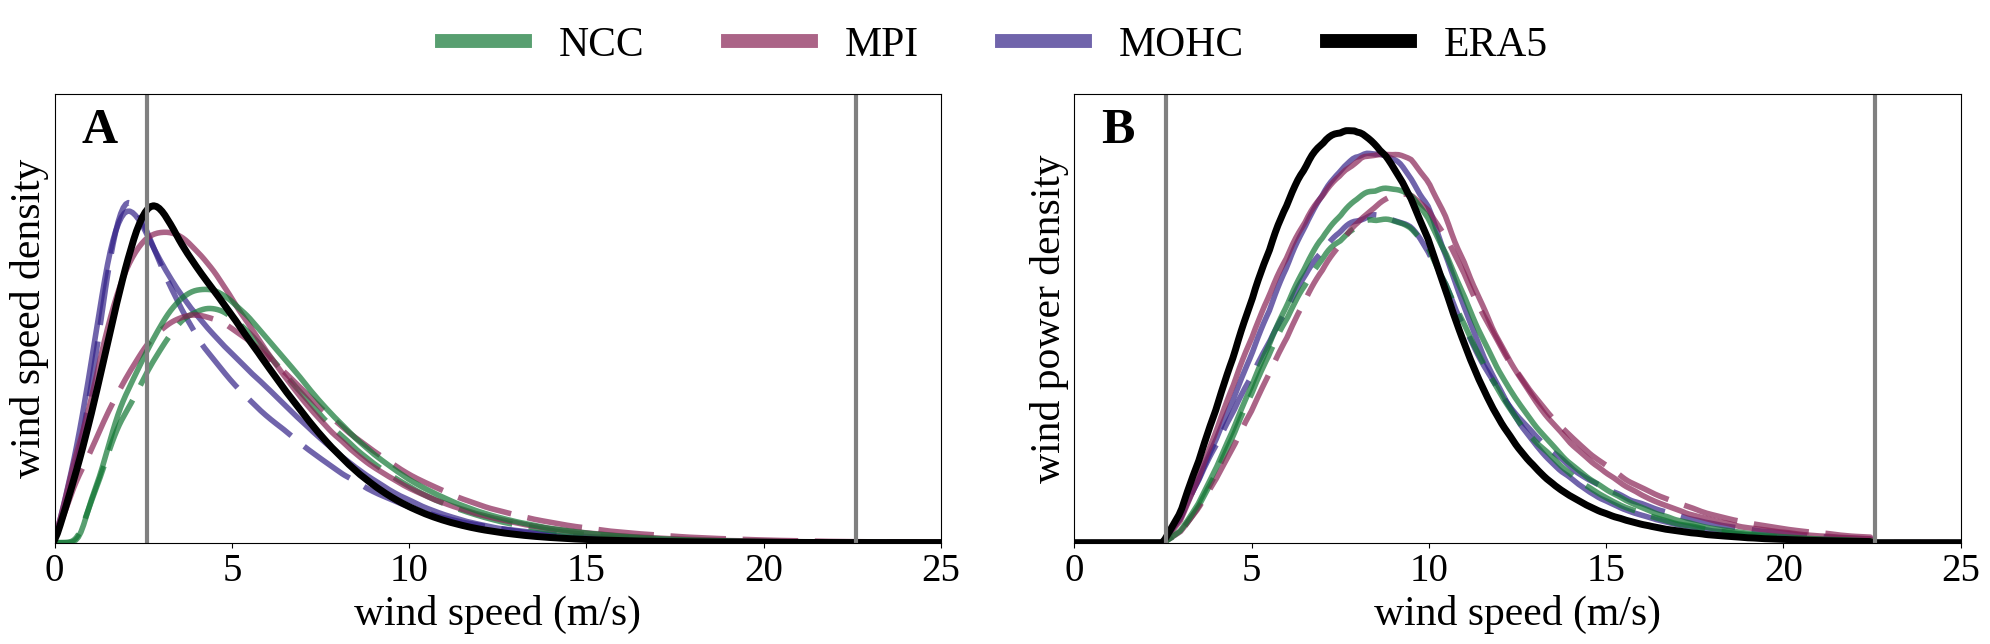

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))
ax=axes[0]
for model_information in list_of_models:
    grid = model_information.grid
    kde = model_information.kde_values
    ax.plot(grid, kde/(sum(kde)), #label=model_information.model_label,
            **model_information.arguments)
configure_axis(ax, 'wind speed density', 'A')
ax.set_ylim(0, 0.02)

ax = axes[1]
for model_information in list_of_models:
    grid = model_information.grid
    kde = model_information.kde_values
    generated_power = compute_wind_power(grid, power_curve_information) * kde
    ax.plot(grid, generated_power/(sum(generated_power)), label=model_information.model_label,
            **model_information.arguments)
configure_axis(ax, 'wind power density', 'B')
ax.set_ylim(0, 0.013)

lines = []
labels = []
for model_name in list(COLORS.keys()):
    if not 'LR' in model_name:
      for file_info in list_of_models:
          if file_info.model_label == model_name:
            model_information = file_info
            line, = ax.plot([], [], label=model_name.replace('-HR', ''),
                            **model_information.arguments)
            lines.append(line)
            labels.append(model_name.replace('-HR', ''))

legend = fig.legend(handles=lines, labels=labels, loc='upper center',
                    bbox_to_anchor=(0.5, 1.1), ncol=4, frameon=False, fontsize=30)
for line in legend.get_lines():
    line.set_linewidth(10)
plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=5)
name = f'distribution_plot_europeland_{hub_height}m_2005-2015'
fig.savefig(f'{name}.pdf', bbox_inches="tight")

In [12]:
list_of_models_all = []
era5_model_file = None
off_set = int(0)
for root, dirs, files in os.walk('/content/drive/MyDrive/Paper Spatial Resolution/kde_values/'):
    for filename in files:
        file_path = os.path.join(root, filename)
        my_file = FileInformation(file_path, off_set)
        if "ERA5" in my_file.model_name:
          era5_model_file = my_file
        else:
          list_of_models_all.append(my_file)
          print(my_file.model_name)
        if 'LR' in my_file.model_label:
          off_set += 5
list_of_models_all.append(era5_model_file)
print(era5_model_file.model_name)

MOHC-LR
MOHC-HR
NCC-LR
MPI-HR
JAP
MPI-LR
NCC-HR
IPSL
CMCC
EC-EARTH
ERA5


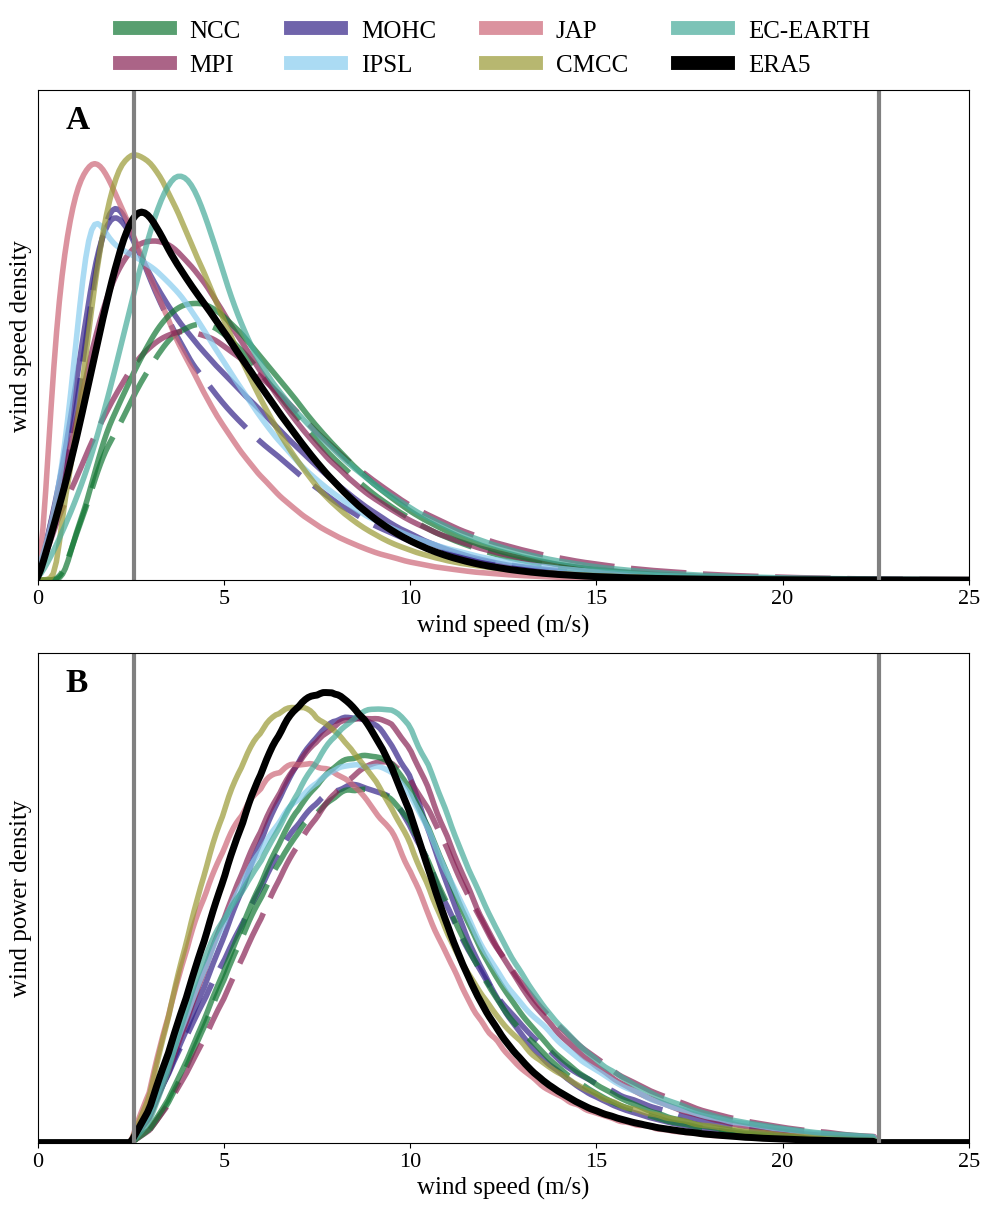

In [20]:
LABEL_SIZE = 18
fig, axes = plt.subplots(2, 1, figsize=(int(FIG_WIDTH/2), 2*FIG_HEIGHT))
ax=axes[0]
for model_information in list_of_models_all:
    grid = model_information.grid
    kde = model_information.kde_values
    ax.plot(grid, kde/(sum(kde)), #label=model_information.model_label,
            **model_information.arguments)
configure_axis(ax, 'wind speed density', 'A')
ax.set_ylim(0, 0.02)

ax = axes[1]
for model_information in list_of_models_all:
    grid = model_information.grid
    kde = model_information.kde_values
    generated_power = compute_wind_power(grid, power_curve_information) * kde
    ax.plot(grid, generated_power/(sum(generated_power)), label=model_information.model_label,
            **model_information.arguments)
configure_axis(ax, 'wind power density', 'B')
ax.set_ylim(0, 0.013)

lines = []
labels = []
for model_name in list(COLORS.keys()):
    if not 'LR' in model_name:
      for file_info in list_of_models_all:
          if file_info.model_label == model_name:
            model_information = file_info
            line, = ax.plot([], [], label=model_name.replace('-HR', ''),
                            **model_information.arguments)
            lines.append(line)
            labels.append(model_name.replace('-HR', ''))

legend = fig.legend(handles=lines, labels=labels, loc='upper center',
                    bbox_to_anchor=(0.5, 1.015), ncol=4, frameon=False, fontsize=18)
for line in legend.get_lines():
    line.set_linewidth(10)
plt.tight_layout(rect=[0, 0, 1, 0.95], w_pad=5)
name = f'distribution_plot_all_europeland_{hub_height}m_2005-2015'
fig.savefig(f'{name}.pdf', bbox_inches="tight")